In [1]:
import re
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

#try:
#    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
#    print("Device:", tpu.master())
#    strategy = tf.distribute.TPUStrategy(tpu)
#except:
#    strategy = tf.distribute.get_strategy()
#print("Number of replicas:", strategy.num_replicas_in_sync)

In [2]:
strategy = tf.test.gpu_device_name()
if len(strategy) > 0:
    print("Found GPU at: {}".format(strategy))
else:
    strategy = "/device:CPU:0"
    print("No GPU, using {}.".format(strategy))

Found GPU at: /device:GPU:0


In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Mar 20 00:58:35 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0    52W / 400W |    659MiB / 40960MiB |      1%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
batch_size = 32
img_height = 180
img_width = 180

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory("/content/gdrive/MyDrive/xray",
                                                      validation_split=0.2,
                                                      subset="training",   
                                                      seed=123,
                                                      image_size=(img_height, img_width),
                                                      batch_size=batch_size
                                                        )

val_ds = tf.keras.utils.image_dataset_from_directory("/content/gdrive/MyDrive/xray",
                                                      validation_split=0.2,
                                                      subset="validation",     
                                                      seed=123,
                                                      image_size=(img_height, img_width),
                                                      batch_size=batch_size
                                                        )


Found 10702 files belonging to 2 classes.
Using 8562 files for training.
Found 10702 files belonging to 2 classes.
Using 2140 files for validation.


In [7]:
AUTOTUNE = tf.data.AUTOTUNE

test_ds = val_ds.take(10) 
val_ds = val_ds.skip(10)

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)



In [8]:
# Gender Classification on TPU

In [9]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 32
IMAGE_SIZE = [180, 180]
#CLASS_NAMES = ["NORMAL", "PNEUMONIA"]

In [10]:
## Build the CNN

In [11]:
from tensorflow import keras
from tensorflow.keras import layers


def conv_block(filters, inputs):
    x = layers.SeparableConv2D(filters, 3, activation="relu", padding="same")(inputs)
    x = layers.SeparableConv2D(filters, 3, activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    outputs = layers.MaxPool2D()(x)

    return outputs


def dense_block(units, dropout_rate, inputs):
    x = layers.Dense(units, activation="relu")(inputs)
    x = layers.BatchNormalization()(x)
    outputs = layers.Dropout(dropout_rate)(x)

    return outputs

In [12]:
def build_model():
    inputs = keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(16, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(16, 3, activation="relu", padding="same")(x)
    x = layers.MaxPool2D()(x)

    x = conv_block(32, x)
    x = conv_block(64, x)

    x = conv_block(128, x)
    x = layers.Dropout(0.2)(x)

    x = conv_block(256, x)
    x = layers.Dropout(0.2)(x)

    x = layers.Flatten()(x)
    x = dense_block(512, 0.7, x)
    x = dense_block(128, 0.5, x)
    x = dense_block(64, 0.3, x)

    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [13]:
## Train the model

In [14]:
### Defining callbacks

In [15]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("xray_model.h5", save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=35, restore_best_weights=True)

In [16]:
initial_learning_rate = 0.015
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True)

In [17]:
### Fit the model

In [18]:
with tf.device(strategy):
    model = build_model()

    METRICS = [
        tf.keras.metrics.AUC(name='AUC'),
    ]
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
        loss="binary_crossentropy",
        metrics=METRICS,
    )

history = model.fit(
    train_ds,
    epochs=100,
    validation_data=val_ds,
    #class_weight=class_weight,
    callbacks=[checkpoint_cb, early_stopping_cb],
  )

Epoch 1/100
268/268 [==============================] - 302s 763ms/step - loss: 0.5533 - AUC: 0.7868 - val_loss: 0.9656 - val_AUC: 0.7576
Epoch 2/100
268/268 [==============================] - 7s 26ms/step - loss: 0.4074 - AUC: 0.8922 - val_loss: 0.6865 - val_AUC: 0.8960
Epoch 3/100
268/268 [==============================] - 7s 25ms/step - loss: 0.3322 - AUC: 0.9306 - val_loss: 0.7729 - val_AUC: 0.8617
Epoch 4/100
268/268 [==============================] - 7s 26ms/step - loss: 0.3104 - AUC: 0.9393 - val_loss: 0.6385 - val_AUC: 0.8479
Epoch 5/100
268/268 [==============================] - 7s 26ms/step - loss: 0.2989 - AUC: 0.9442 - val_loss: 0.2298 - val_AUC: 0.9672
Epoch 6/100
268/268 [==============================] - 7s 25ms/step - loss: 0.2389 - AUC: 0.9640 - val_loss: 0.2672 - val_AUC: 0.9627
Epoch 7/100
268/268 [==============================] - 7s 26ms/step - loss: 0.2460 - AUC: 0.9619 - val_loss: 0.5590 - val_AUC: 0.9430
Epoch 8/100
268/268 [==============================] - 7s 2

In [19]:
## Visualizing model performance

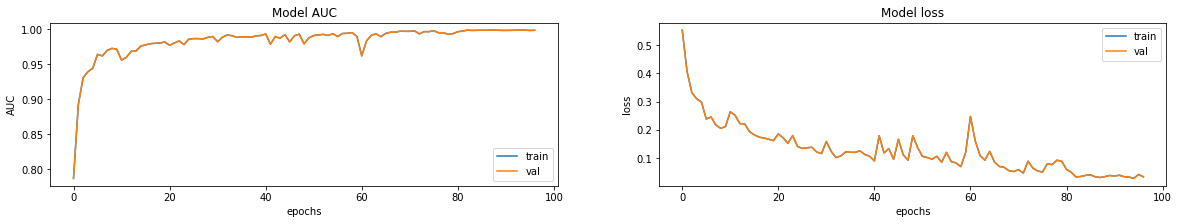

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(["AUC", "loss"]):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history[met])
    ax[i].set_title("Model {}".format(met))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])

In [22]:
### Predict and evaluate results

In [23]:
model.evaluate(test_ds, return_dict=True)

10/10 [==============================] - 2s 116ms/step - loss: 0.1100 - AUC: 0.9932


{'loss': 0.11000128090381622, 'AUC': 0.9932039380073547}

In [24]:
#for image, label in test_ds.take(1):
#  print("Image shape: ", image.numpy().shape)
#  print("Label: ", label.numpy())

In [25]:
# imageId - same as the PNG filename
# gender - 0 for female and 1 for male
CLASS_NAMES = ["FEMALE", "MALE"]

In [26]:
test = keras.preprocessing.image_dataset_from_directory(
    "/content/gdrive/MyDrive/xraytest", 
    batch_size=32, 
    image_size=(img_height, img_width), shuffle=False
)
file_paths = test.file_paths
test = test.cache().prefetch(buffer_size=AUTOTUNE)

Found 11747 files belonging to 1 classes.


In [27]:
dict = {'imageId': file_paths}
df = pd.DataFrame(dict)
df['imageId'] = df.imageId.str.split('/').str[6]
df['imageId'] = df.imageId.str.split('.').str[0]
df['imageId'] = df['imageId'].astype(int)
df.head()

,imageId
0,0
1,1
2,2
3,3
4,4


In [28]:
preds = model.predict(test, batch_size=batch_size)
#preds = preds.round(2)
preds = np.squeeze(preds)

368/368 [==============================] - 754s 2s/step


In [29]:
df['gender'] = preds

In [30]:
df.head()

,imageId,gender
0,0,0.768106
1,1,0.008622
2,2,0.998439
3,3,0.006314
4,4,0.816272


In [31]:
def label_classes(pred_probs, threshold=0.5):
    """
    Takes in a list of predicted probabilities and returns a list of class labels.
    The class labels are determined by comparing each probability to a threshold value.
    If the probability is greater than or equal to the threshold, the label is 1. Otherwise, it is 0.
    Args:
        pred_probs (list): A list of predicted probabilities.
        threshold (float): The probability threshold for determining the class label. Default is 0.5.
    Returns:
        A list of class labels (0 or 1) corresponding to each predicted probability.
    """
    class_labels = []
    for prob in pred_probs:
        if prob >= threshold:
            class_labels.append(1)
        else:
            class_labels.append(0)
    return class_labels

df['gender'] = label_classes(df['gender'], threshold=0.5)

In [32]:
df.to_csv('/content/gdrive/MyDrive/submission_gender.csv', index=False)

In [33]:
df.head()

,imageId,gender
0,0,1
1,1,0
2,2,1
3,3,0
4,4,1


In [ ]:
for image, label in test.take(1):
  for j in range(0,30):
    prediction = model.predict(test_ds.take(1))[j]
    scores = [1 - prediction, prediction]
    for score, name in zip(scores, CLASS_NAMES):
        print("This image is %.2f percent %s" % ((100 * score), name))
    plt.imshow(image[j] / 255.0)
    plt.title(CLASS_NAMES[label[j].numpy()])
    plt.show()